In [11]:
import matplotlib.pyplot as plt
import json
import numpy as np
import os

from src.data_models.positional.waypoint import Waypoint, Waypoints
from src.data_models.probability_map import ProbabilityMap
from src.waypoint_generation.waypoint_factory import WaypointFactory, WaypointAlgorithmEnum

In [15]:
from src.waypoint_generation import CostFunc
cost_func = CostFunc()

with open(os.path.join(os.getcwd(), 'src','waypoint_generation','global.settings'),'r') as f:
    wp_gen_settings = json.load(f)

Starting matlab engine...
Matlab engine started as <src.matlab_helper.MatlabHelper object at 0x7feecc43d190>


In [3]:
with open("algorithms_output.json", 'r') as f:
    data = json.loads(json.load(f))
    
img = np.array(data['img'])
del data['img']

for key in WaypointAlgorithmEnum:
    key = str(key)
    try:
        dat = data[key]
        wps = Waypoints(dat['wps'])        
        dat['wps'] = wps
        data[key].update(dat)
        print(f"{key} does exist ({len(wps)} wps)")
    except KeyError:
        print(f"{key} doesn't exist")

data

WaypointAlgorithmEnum.LHC_GW_CONV does exist (120 wps)
WaypointAlgorithmEnum.PARALLEL_SWATHS does exist (23 wps)
WaypointAlgorithmEnum.MODIFIED_LAWNMOWER does exist (25 wps)
WaypointAlgorithmEnum.PABO does exist (16 wps)


{'WaypointAlgorithmEnum.PARALLEL_SWATHS': {'wps': <src.data_models.positional.waypoint.Waypoints at 0x7fee869afdc0>,
  'time': 0.003098011016845703},
 'WaypointAlgorithmEnum.MODIFIED_LAWNMOWER': {'wps': <src.data_models.positional.waypoint.Waypoints at 0x7fee869b17c0>,
  'time': 465.6427571773529},
 'WaypointAlgorithmEnum.PABO': {'wps': <src.data_models.positional.waypoint.Waypoints at 0x7fee869b2280>,
  'time': 121.32462453842163},
 'WaypointAlgorithmEnum.LHC_GW_CONV': {'wps': <src.data_models.positional.waypoint.Waypoints at 0x7fee869a5790>,
  'time': 28.05168318748474}}

WaypointAlgorithmEnum.PARALLEL_SWATHS
121.4142 units long
0.0031s


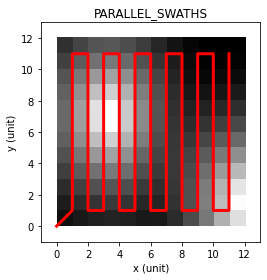

WaypointAlgorithmEnum.MODIFIED_LAWNMOWER
158.4142 units long
465.6428s


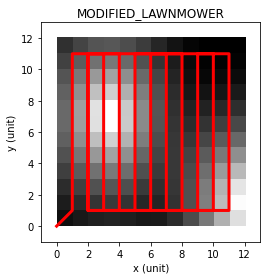

WaypointAlgorithmEnum.PABO
108.1935 units long
121.3246s


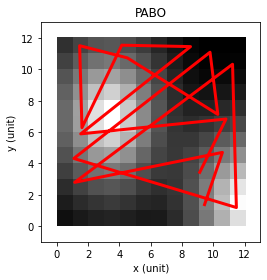

WaypointAlgorithmEnum.LHC_GW_CONV
139.2965 units long
28.0517s


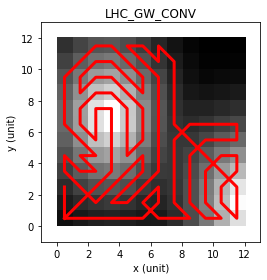

In [4]:
def plot(alg):
    fig, ax = plt.subplots()
    
    ax.imshow(img, interpolation=None,origin='bottom', extent=[0, img.shape[0], 0, img.shape[1]], cmap='gray')
    wps = data[str(alg)]['wps'].toNumpyArray()
    
    dist = np.sum(np.linalg.norm(wps[1:] - wps[:-1],axis=1))
    
    
    
    ax.plot(wps[:,0],wps[:,1],'r',linewidth=3)
        
    ax.set_xlim(-1,img.shape[0]+1)
    ax.set_ylim(-1,img.shape[1]+1)
    ax.set_xlabel("x (unit)")
    ax.set_ylabel("y (unit)")
    
    s = str(alg).split('.')[1]
    fig.savefig(s+"_path.png")
    ax.set_title(s)
    
    return fig,ax,dist
    
    
for key in data.keys():
    fig,ax,dist = plot(key)
    print(f"{key}\n{dist:.4f} units long\n{data[key]['time']:.4f}s")
    plt.tight_layout()
    plt.show()
    data[key]['dist'] = dist

In [5]:
def plot_bar(x,y,x_label,y_label):

    fig,ax = plt.subplots()
    plt.xticks(rotation=45)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.grid(True, linestyle='--', which='major',
                       color='grey', alpha=.25)
    ax.bar(x,y)   

    return fig,ax

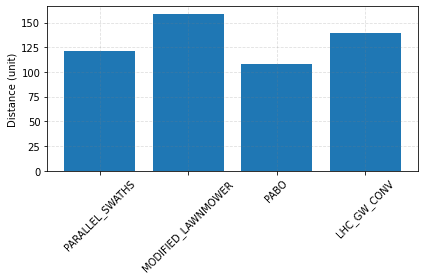

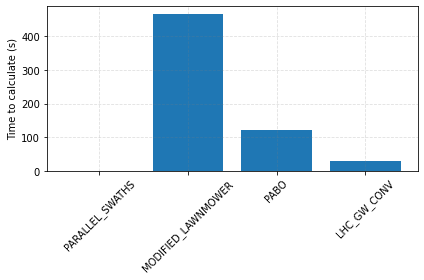

In [6]:
dists = [item[1]['dist'] for item in data.items()]
times = [item[1]['time'] for item in data.items()]

x = [str(s).split('.')[1] for s in data.keys()]

fig,ax=plot_bar(x,dists,"","Distance (unit)")
plt.tight_layout()
fig.savefig("unit_distances_all.png")

fig,ax=plot_bar(x,times,"","Time to calculate (s)")
plt.tight_layout()
fig.savefig("time_to_calculate_all.png")

WaypointAlgorithmEnum.PARALLEL_SWATHS
WaypointAlgorithmEnum.MODIFIED_LAWNMOWER
WaypointAlgorithmEnum.PABO
WaypointAlgorithmEnum.LHC_GW_CONV


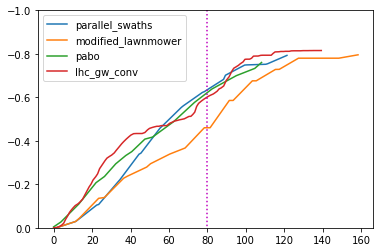

In [18]:
# Cost over distance

for key in data.keys():
    wps = data[key]['wps'].toNumpyArray()
    cost_over_wps = []
    dist_with_wps = np.cumsum([0]+[np.linalg.norm(g-f) for g,f in zip(wps[:-1],wps[1:])])
    for i in range(len(wps)):
        tmp_wps = Waypoints(wps[:i+1])
        cost = cost_func.calculate(tmp_wps,ProbabilityMap(img),onlyAccumulateProbability=True)
        cost_over_wps.append(cost)
    
    print(key)
    plt.plot(dist_with_wps,cost_over_wps, label=key.split('.')[1].lower())
plt.ylim([0, -1])
plt.legend()

plt.plot((wp_gen_settings['unit_endurance'],)*2,[-1, 1],'m:')
plt.show()

(2, 2)